In [ ]:
## Do this only in Colab notebooks! Otherwise use pip install unsloth
#!pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl==0.15.2 triton cut_cross_entropy unsloth_zoo
#!pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
#!pip install --no-deps unsloth

In [1]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch
from pathlib import Path


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth Zoo will now patch everything to make training faster!


## Qwen2.5 7b finetuned

In [48]:
model_path = "/data/models/qwen2_5_ 7b_outputs"


In [2]:
base_data_dir = Path("/data")

In [3]:
from peft import PeftModel
from transformers import AutoModelForCausalLM, AutoTokenizer, Qwen2_5_VLForConditionalGeneration


In [53]:
model, tokenizer = FastVisionModel.from_pretrained(
    model_path,
    load_in_4bit=True,
    #use_gradient_checkpointing="unsloth",
)

==((====))==  Unsloth 2025.4.7: Fast Qwen2 patching. Transformers: 4.51.3.
   \\   /|    NVIDIA RTX A5000. Num GPUs = 1. Max memory: 23.679 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 8.6. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [97]:
del model
del tokenizer

In [4]:
import torch
import gc
from pathlib import Path
from unsloth import FastVisionModel
from PIL import Image

class QwenProcessor:
    def __init__(self):
        self.base_data_dir = Path("/data")
        self.model_mapper = {
            "Qwen2_5-3b_finetuned": str(self.base_data_dir / "models/qwen2_5_3b_outputs"),
            "Qwen2_5-7b_finetuned": str(self.base_data_dir / "models/qwen2_5_ 7b_outputs"),
            "Qwen2-vl-7b_finetuned": str(self.base_data_dir / "models/qwen2_VL_7b/lora_model"),
            "Qwen2_5-3b": "unsloth/Qwen2.5-VL-3B-Instruct",
            "Qwen2_5-7b": "unsloth/Qwen2.5-VL-7B-Instruct",
            "Qwen2-vl-7b": "unsloth/Qwen2-VL-7B-Instruct"   
        }
        self.loaded_models = {}

    def get_available_models(self):
        return self.model_mapper.keys()

    def clear_cache(self):
        gc.collect()
        torch.cuda.empty_cache()
        
    def unload_model(self, model):
        del model
        self.clear_cache()

    def load_model(self, model_name):
        # Если модель уже загружена — вернуть её
        if model_name in self.loaded_models:
            return self.loaded_models[model_name]

        # Выгрузить другие модели
        for name, (model, _) in self.loaded_models.items():
            if name != model_name:
                self.unload_model(model)
        self.loaded_models.clear()

        # Загрузить модель
        model, tokenizer = FastVisionModel.from_pretrained(
            self.model_mapper[model_name],
            load_in_4bit=True,
            #use_gradient_checkpointing="unsloth",
        )
        FastVisionModel.for_inference(model)
        self.loaded_models[model_name] = (model, tokenizer)
        return model, tokenizer

    def process(self, system_prompt, user_prompt, image: Image, selected_model, temperature=0.2):
        model, tokenizer = self.load_model(selected_model)
        messages = [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": [
                {"type": "image"},
                {"type": "text", "text": user_prompt}
            ]}
        ]
        input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)

        inputs = tokenizer(
            [image],  # Убедитесь, что это список
            [input_text],
            add_special_tokens=False,
            return_tensors="pt",
        ).to("cuda")

        input_ids = inputs["input_ids"][0]

        output_ids = model.generate(
            **inputs,
            max_new_tokens=128,
            use_cache=True,
            temperature=temperature,
            min_p=0.1,
        )[0]

        # Удаляем prompt, оставляя только сгенерированное
        generated_only_ids = output_ids[len(input_ids):]

        # Преобразуем выход модели в текст
        recognized_text = tokenizer.decode(generated_only_ids, skip_special_tokens=True)

        return f"{recognized_text}"


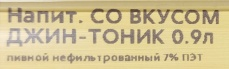

In [6]:
 sample_image = Image.open(base_data_dir / "names/44.jpg")
sample_image

In [7]:
!nvidia-smi

Thu Jun 12 15:29:09 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.216.03             Driver Version: 535.216.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A5000               Off | 00000000:00:06.0 Off |                  Off |
| 30%   30C    P8               6W / 230W |    412MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [8]:
qwen_processor = QwenProcessor()
qwen_processor.clear_cache()
qwen_processor.load_model("Qwen2_5-7b_finetuned")

==((====))==  Unsloth 2025.4.7: Fast Qwen2 patching. Transformers: 4.51.3.
   \\   /|    NVIDIA RTX A5000. Num GPUs = 1. Max memory: 23.679 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 8.6. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


(PeftModelForCausalLM(
   (base_model): LoraModel(
     (model): Qwen2_5_VLForConditionalGeneration(
       (visual): Qwen2_5_VisionTransformerPretrainedModel(
         (patch_embed): Qwen2_5_VisionPatchEmbed(
           (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
         )
         (rotary_pos_emb): Qwen2_5_VisionRotaryEmbedding()
         (blocks): ModuleList(
           (0-25): 26 x Qwen2_5_VLVisionBlock(
             (norm1): Qwen2RMSNorm((1280,), eps=1e-06)
             (norm2): Qwen2RMSNorm((1280,), eps=1e-06)
             (attn): Qwen2_5_VLVisionSdpaAttention(
               (qkv): lora.Linear(
                 (base_layer): Linear(in_features=1280, out_features=3840, bias=True)
                 (lora_dropout): ModuleDict(
                   (default): Identity()
                 )
                 (lora_A): ModuleDict(
                   (default): Linear(in_features=1280, out_features=16, bias=False)
                 )
                 (lo

In [68]:
SYSTEM_PROMPT  = '''
Вы — ассистент OCR , который извлекает информацию с русских товарных этикеток на изображениях. В тексте могут встречаться названия на английском.

'''

USER_PROMPT = '''
Пожалуйста, извлеките весь текст на изображении и ничего больше без комментариев. 

'''

In [72]:
import time

In [105]:
start_time = time.time()
result_text = qwen_processor.process(SYSTEM_PROMPT, USER_PROMPT, sample_image, "Qwen2_5-7b_finetuned", temperature=0.2)
end_time = time.time()

print(end_time - start_time)
print(result_text)

==((====))==  Unsloth 2025.4.7: Fast Qwen2 patching. Transformers: 4.51.3.
   \\   /|    NVIDIA RTX A5000. Num GPUs = 1. Max memory: 23.679 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 8.6. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


ValueError: Some modules are dispatched on the CPU or the disk. Make sure you have enough GPU RAM to fit the quantized model. If you want to dispatch the model on the CPU or the disk while keeping these modules in 32-bit, you need to set `llm_int8_enable_fp32_cpu_offload=True` and pass a custom `device_map` to `from_pretrained`. Check https://huggingface.co/docs/transformers/main/en/main_classes/quantization#offload-between-cpu-and-gpu for more details. 